In [1]:
write_images = False

In [2]:
import numpy as np

In [3]:
def catapult_distance(x):
    """Request user input for the catapult."""
    y = np.zeros((x.shape[0], 1))
    for i in range(x.shape[0]):
        rotation_axis=x[i, 0]
        arm_stop=x[i, 1]
        spring_binding_1=x[i, 2]
        spring_binding_2=x[i, 3]
            
        print('Please set the following values:')
        print('x_1 = {rotation_axis:.2f} (rotation axis)'.format(rotation_axis=rotation_axis))
        print('x_2 = {arm_stop:.2f} (arm stop)'.format(arm_stop=arm_stop))
        print('x_3 = {spring_binding_1:.2f} (spring binding 1)'.format(spring_binding_1=spring_binding_1))
        print('x_4 = {spring_binding_2:.2f} (spring binding 2)'.format(spring_binding_2=spring_binding_2))
        y[i, 0] = float(input('What is the distance? '))
    return y

In [4]:
from emukit.core import ContinuousParameter, ParameterSpace

In [5]:
variable_domain = [0,1]
           
space = ParameterSpace(
          [ContinuousParameter('rotation_axis', *variable_domain), 
           ContinuousParameter('arm_stop', *variable_domain),
           ContinuousParameter('spring_binding_1', *variable_domain),
           ContinuousParameter('spring_binding_2', *variable_domain)])

## Experimental design

In [6]:
from emukit.core.initial_designs import RandomDesign



In [7]:
design = RandomDesign(space)
x = design.get_samples(5)
y = catapult_distance(x)

Please set the following values:
x_1 = 0.26 (rotation axis)
x_2 = 0.16 (arm stop)
x_3 = 0.46 (spring binding 1)
x_4 = 1.00 (spring binding 2)
What is the distance? 12
Please set the following values:
x_1 = 0.73 (rotation axis)
x_2 = 0.30 (arm stop)
x_3 = 0.82 (spring binding 1)
x_4 = 0.76 (spring binding 2)
What is the distance? 10
Please set the following values:
x_1 = 0.57 (rotation axis)
x_2 = 0.45 (arm stop)
x_3 = 0.99 (spring binding 1)
x_4 = 0.26 (spring binding 2)
What is the distance? 4
Please set the following values:
x_1 = 0.09 (rotation axis)
x_2 = 0.53 (arm stop)
x_3 = 0.51 (spring binding 1)
x_4 = 0.09 (spring binding 2)
What is the distance? 5
Please set the following values:
x_1 = 0.50 (rotation axis)
x_2 = 0.22 (arm stop)
x_3 = 0.46 (spring binding 1)
x_4 = 0.79 (spring binding 2)
What is the distance? 2


In [8]:
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.sensitivity.monte_carlo import MonteCarloSensitivity


In [20]:
from GPy import kern
# from GPy import likelihoods

model_gpy = GPRegression(
    X=x, 
    Y=y, 
    kernel=kern.RBF(x.shape[1]), 
    normalizer=False,
    noise_var=1.
)
# Should default to Gaussian likelihood with 0 mean and noise_var variance 
# likelihood = likelihoods.Gaussian(variance=noise_var)
model_gpy.kern.variance = 150**2
model_gpy.likelihood.variance.fix(1e-5) # Change noise_var
display(model_gpy)

GP_regression.,value,constraints,priors
rbf.variance,22500.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [21]:
model_emukit = GPyModelWrapper(model_gpy)
model_emukit.optimize()

In [22]:
display(model_gpy)

GP_regression.,value,constraints,priors
rbf.variance,57.16879426318768,+ve,
rbf.lengthscale,0.1887774370217395,+ve,
Gaussian_noise.variance,1e-05,+ve fixed,


In [12]:
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance


In [23]:
integrated_variance = IntegratedVarianceReduction(space=space,
                                                  model=model_emukit)
ed = ExperimentalDesignLoop(space=space, 
                            model=model_emukit, 
                            acquisition = integrated_variance)
ed.run_loop(catapult_distance, 10)


Please set the following values:
x_1 = 0.59 (rotation axis)
x_2 = 0.52 (arm stop)
x_3 = 0.33 (spring binding 1)
x_4 = 0.38 (spring binding 2)
What is the distance? 2
Please set the following values:
x_1 = 0.37 (rotation axis)
x_2 = 0.68 (arm stop)
x_3 = 0.68 (spring binding 1)
x_4 = 0.64 (spring binding 2)
What is the distance? 25
Please set the following values:
x_1 = 0.72 (rotation axis)
x_2 = 0.73 (arm stop)
x_3 = 0.31 (spring binding 1)
x_4 = 0.74 (spring binding 2)
What is the distance? 13
Please set the following values:
x_1 = 0.62 (rotation axis)
x_2 = 0.76 (arm stop)
x_3 = 0.70 (spring binding 1)
x_4 = 0.25 (spring binding 2)
What is the distance? 26
Please set the following values:
x_1 = 0.28 (rotation axis)
x_2 = 0.70 (arm stop)
x_3 = 0.19 (spring binding 1)
x_4 = 0.52 (spring binding 2)
What is the distance? 5
Please set the following values:
x_1 = 0.70 (rotation axis)
x_2 = 0.29 (arm stop)
x_3 = 0.30 (spring binding 1)
x_4 = 0.30 (spring binding 2)
What is the distance? 23


## Sensitivity Analysis

In [24]:
num_mc = 10000
senstivity = MonteCarloSensitivity(model = model_emukit, input_domain = space)
main_effects_gp, total_effects_gp, _ = senstivity.compute_effects(num_monte_carlo_points = num_mc)

In [25]:
import matplotlib.pyplot as plt
import mlai.plot as plot
import mlai

In [26]:
import pandas as pd


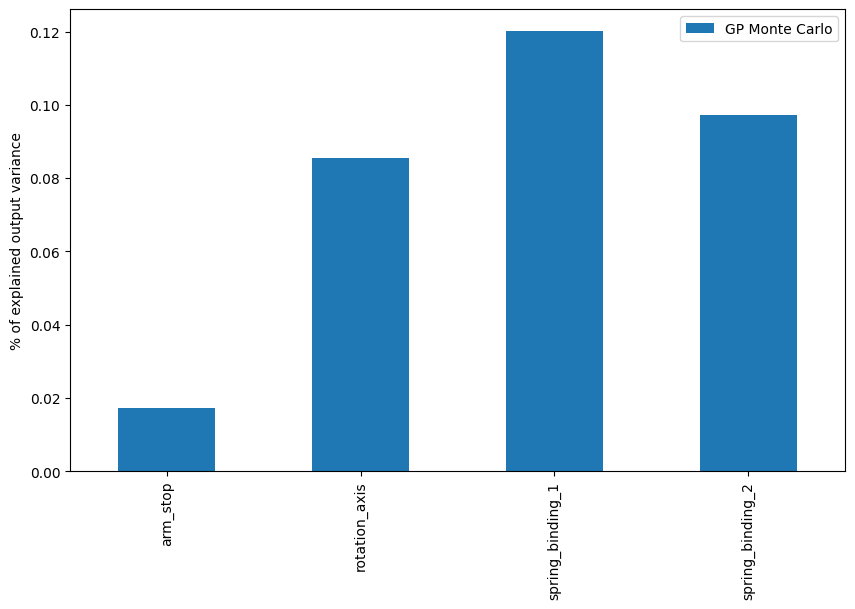

In [27]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

main_effects_gp_plot = {ivar: main_effects_gp[ivar][0] for ivar in main_effects_gp}

d = {'GP Monte Carlo':main_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
plt.ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='first-order-sobol-indices-gp-catapult.svg', directory='./uq')


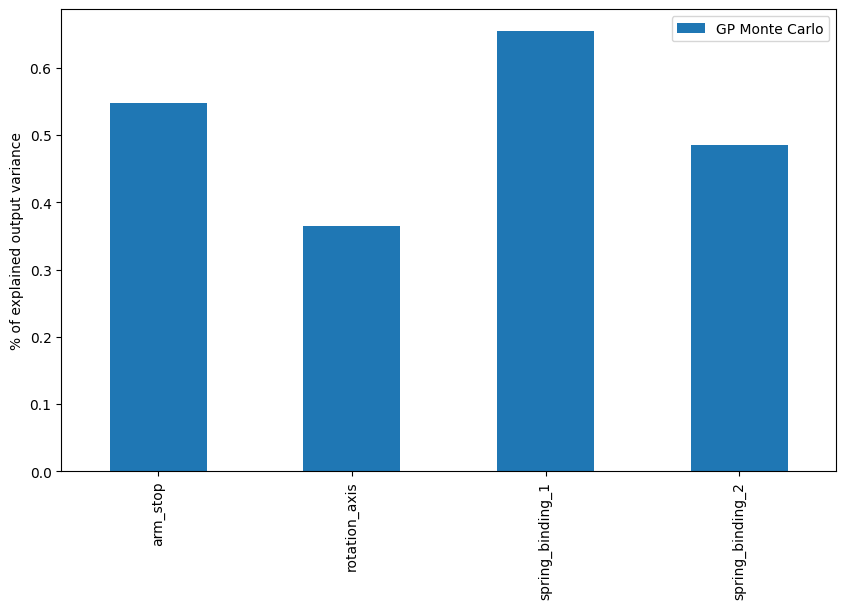

In [28]:
fig, ax = plt.subplots(figsize=plot.big_wide_figsize)

total_effects_gp_plot = {ivar: total_effects_gp[ivar][0] for ivar in total_effects_gp}

d = {'GP Monte Carlo':total_effects_gp_plot}

pd.DataFrame(d).plot(kind='bar', ax=ax)
ax.set_ylabel('% of explained output variance')

if write_images:
    mlai.write_figure(filename='total-effects-sobol-indices-gp-catapult.svg', directory='./uq')